In [1]:
import argparse
import os
import pprint
import shutil
import sys
import random

import logging
import time
import timeit
from pathlib import Path

import numpy as np

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim

from seg_hrnet import get_seg_model

In [3]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [3, 3]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

#!pip install yacs
from yacs.config import CfgNode as CN

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
device

device(type='cpu')

In [5]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

In [6]:
image_folder = '/Users/qianjing/Downloads/data'
annotation_csv = '/Users/qianjing/Downloads/data/annotation.csv'

In [7]:
from yacs.config import CfgNode as CN
import yaml

In [8]:
# You shouldn't change the unlabeled_scene_index
# The first 106 scenes are unlabeled
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)

In [9]:
dataset_size = len(labeled_scene_index)
indices = list(range(dataset_size))
indices = np.random.shuffle(indices)
split = int(dataset_size * 0.8 )
train_indices, val_indices = labeled_scene_index[:split], labeled_scene_index[split:]

In [10]:
transform = torchvision.transforms.ToTensor()
# labeled_trainset = LabeledDataset(image_folder=image_folder,
#                                   annotation_file=annotation_csv,
#                                   scene_index=train_indices,
#                                   transform=transform,
#                                   extra_info=False
#                                  )
# trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=3, shuffle=True, num_workers=2, collate_fn=collate_fn)
labeled_valset = LabeledDataset(image_folder=image_folder,
                                    annotation_file=annotation_csv,
                                    scene_index=val_indices,
                                    transform=transform,
                                    extra_info=False
                                    )
#trainloader = torch.utils.data.DataLoader(labeled_trainset, batch_size=3, shuffle=True, num_workers=2,collate_fn=collate_fn)
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=3, shuffle=True, num_workers=2,
                                            collate_fn=collate_fn)

# # unlabeled_trainset = UnlabeledDataset(image_folder=image_folder, scene_index=labeled_scene_index, first_dim='sample', transform=transform)
# trainloader = torch.utils.data.DataLoader(unlabeled_trainset, batch_size=3, shuffle=True, num_workers=2)

In [16]:
_C = CN()

_C.OUTPUT_DIR = ''
_C.LOG_DIR = ''
_C.GPUS = (0,)
_C.WORKERS = 4
_C.PRINT_FREQ = 20
_C.AUTO_RESUME = False
_C.PIN_MEMORY = True
_C.RANK = 0

# Cudnn related params
_C.CUDNN = CN()
_C.CUDNN.BENCHMARK = True
_C.CUDNN.DETERMINISTIC = False
_C.CUDNN.ENABLED = True

# common params for NETWORK
_C.MODEL = CN()
_C.MODEL.NAME = 'seg_hrnet'
_C.MODEL.PRETRAINED = ''
_C.MODEL.EXTRA = CN(new_allowed=True)

_C.LOSS = CN()
_C.LOSS.USE_OHEM = False
_C.LOSS.OHEMTHRES = 0.9
_C.LOSS.OHEMKEEP = 100000
_C.LOSS.CLASS_BALANCE = True

# DATASET related params
_C.DATASET = CN()
_C.DATASET.ROOT = ''
_C.DATASET.NUM_CLASSES = 1
_C.DATASET.EXTRA_TRAIN_SET = ''

# training
_C.TRAIN = CN()

_C.TRAIN.IMAGE_SIZE = [1024, 512]  # width * height
_C.TRAIN.BASE_SIZE = 2048
_C.TRAIN.DOWNSAMPLERATE = 1
_C.TRAIN.FLIP = True
_C.TRAIN.MULTI_SCALE = True
_C.TRAIN.SCALE_FACTOR = 16

_C.TRAIN.LR_FACTOR = 0.1
_C.TRAIN.LR_STEP = [90, 110]
_C.TRAIN.LR = 0.0001
_C.TRAIN.EXTRA_LR = 0.001

_C.TRAIN.OPTIMIZER = 'sgd'
_C.TRAIN.MOMENTUM = 0.9
_C.TRAIN.WD = 0.0001
_C.TRAIN.NESTEROV = False
_C.TRAIN.IGNORE_LABEL = -1

_C.TRAIN.BEGIN_EPOCH = 0
_C.TRAIN.END_EPOCH = 484
_C.TRAIN.EXTRA_EPOCH = 0

_C.TRAIN.RESUME = False

_C.TRAIN.BATCH_SIZE_PER_GPU = 32
_C.TRAIN.SHUFFLE = True
# only using some training samples
_C.TRAIN.NUM_SAMPLES = 0

# testing
_C.TEST = CN()

_C.TEST.IMAGE_SIZE = [2048, 1024]  # width * height
_C.TEST.BASE_SIZE = 2048

_C.TEST.BATCH_SIZE_PER_GPU = 32
# only testing some samples
_C.TEST.NUM_SAMPLES = 0

_C.TEST.MODEL_FILE = ''
_C.TEST.FLIP_TEST = False
_C.TEST.MULTI_SCALE = False
_C.TEST.SCALE_LIST = [1]

# debug
_C.DEBUG = CN()
_C.DEBUG.DEBUG = False
_C.DEBUG.SAVE_BATCH_IMAGES_GT = False
_C.DEBUG.SAVE_BATCH_IMAGES_PRED = False
_C.DEBUG.SAVE_HEATMAPS_GT = False
_C.DEBUG.SAVE_HEATMAPS_PRED = False
_C.defrost()
_C.merge_from_file("scratch.yml")
_C.freeze()
    
config = _C

In [19]:
PATH = 'exp_models/lr_epoch1_try_try.pt'
model = get_seg_model(config)
model.load_state_dict(torch.load(PATH,map_location='cpu'))

HighResolutionNet(
  (conv1): Conv2d(18, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (relu): ReLU()
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (relu): ReLU()
      (do

In [21]:
criterion = nn.BCELoss()

In [20]:
def threat_score(tp,fp,tn,fn,pred,road_image):
    output_class = (pred > 0.5).float()
    ##tp is where prediction class = road_image class = 1
    tp_tmp = torch.sum(torch.mul(output_class, road_image))
    ##fp is where prediction class = 1 and road_image = 0
    fp_tmp = ((output_class - road_image) == 1).sum()
    ###tn is where prediction class = road_image class = 0
    tn_tmp = ((output_class - road_image) == 0).sum() - tp_tmp
    ## fn is where prediction class = 0 and road_image = 1
    fn_tmp = ((output_class - road_image) == -1).sum()
    tp += tp_tmp
    fp += fp_tmp
    tn += tn_tmp
    fn += fn_tmp
    tmp_ts = tp_tmp / (tp_tmp + fp_tmp + fn_tmp)
    return tp,fp,tn,fn,tmp_ts

In [30]:
sample, target, road_image = next(iter(valloader))
sample, road_image = torch.stack(sample).to(device), torch.stack(road_image).float().to(device)
sample = sample.view(sample.shape[0], -1, 256, 306)
def eval_single(sample,model,road_image):
    model.eval()
    pred = model(sample)
    loss = criterion(pred, road_image)
    print("Loss is: ",loss)
    tp,fp,tn,fn = 0,0,0,0
    tp,fp,tn,fn,tmp_ts = threat_score(tp,fp,tn,fn,pred,road_image)
    ts = tp / (tp + fp + fn)
    print("threat score for this example is: ", ts)
    return road_image,pred

In [31]:
road_image,pred  = eval_single(sample,model,road_image)

Loss is:  tensor(0.3585, grad_fn=<BinaryCrossEntropyBackward>)
threat score for this example is:  tensor(0.6850)


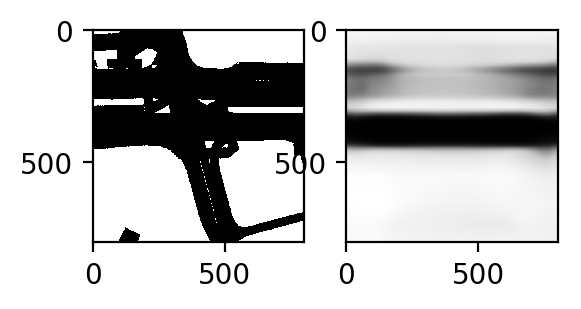

In [27]:
####1 epoch result######
fig, ax = plt.subplots(1,2)
ax[0].imshow(road_image[2], cmap='binary');
ax[1].imshow(pred[2].detach().numpy(), cmap='binary');

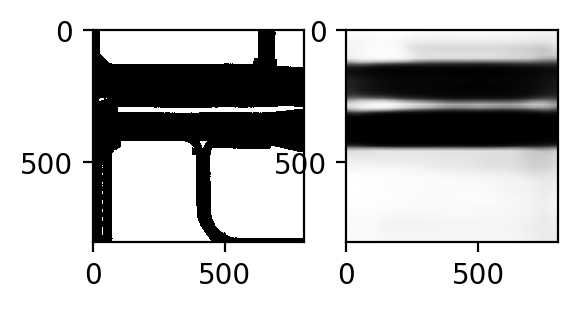

In [28]:
####1 epoch result######
fig, ax = plt.subplots(1,2)
ax[0].imshow(road_image[1], cmap='binary');
ax[1].imshow(pred[1].detach().numpy() , cmap='binary');

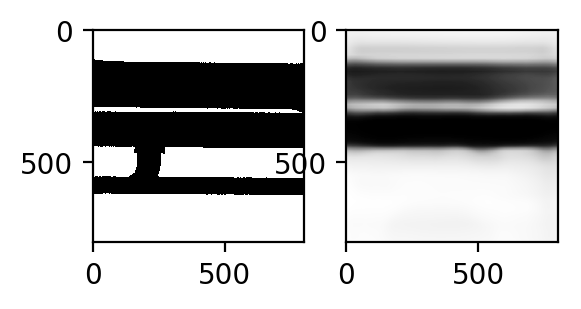

In [29]:
## 1 epoch result
fig, ax = plt.subplots(1,2)
ax[0].imshow(road_image[0], cmap='binary');
ax[1].imshow(pred[0].detach().numpy(), cmap='binary');

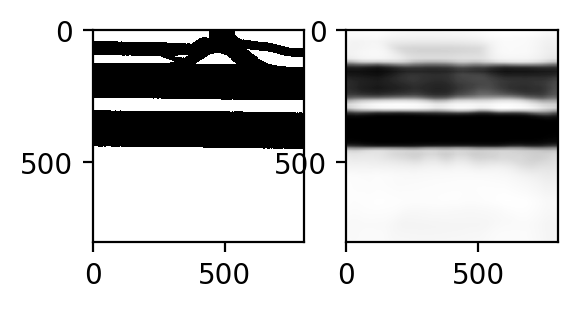

In [32]:
####1 epoch result######
fig, ax = plt.subplots(1,2)
ax[0].imshow(road_image[2], cmap='binary');
ax[1].imshow(pred[2].detach().numpy(), cmap='binary');

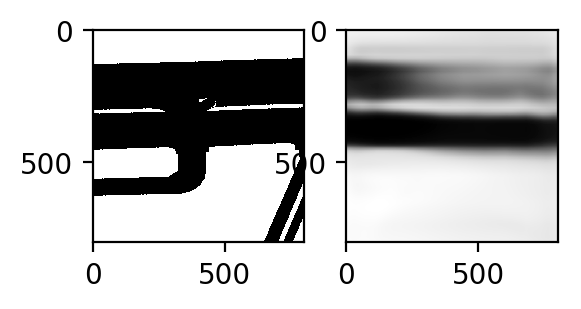

In [33]:
####1 epoch result######
fig, ax = plt.subplots(1,2)
ax[0].imshow(road_image[1], cmap='binary');
ax[1].imshow(pred[1].detach().numpy(), cmap='binary');

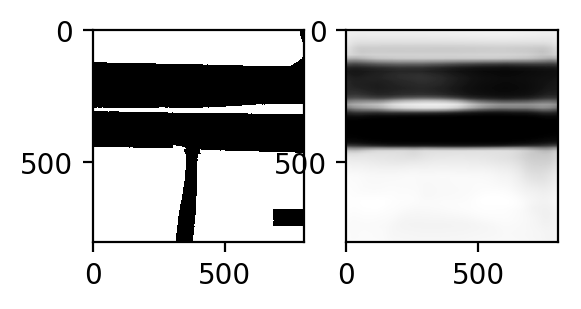

In [34]:
####1 epoch result######
fig, ax = plt.subplots(1,2)
ax[0].imshow(road_image[0], cmap='binary');
ax[1].imshow(pred[0].detach().numpy(), cmap='binary');

In [15]:
def eval_bev(valloader, model, criterion):
    model.eval()
    total_loss = 0
    tp,fp,tn,fn = 0,0,0,0
    t_scores = []
    for i, (sample, target, road_image) in enumerate(valloader):
        sample, road_image = torch.stack(sample).to(device), torch.stack(road_image).float().to(device)
        sample = sample.view(sample.shape[0], -1, 256, 306)  # torch.Size([3, 18, 256, 306])
        with torch.no_grad():
            pred = model(sample)
        print(pred)
        loss = criterion(pred, road_image)
        total_loss += loss.item()
        tp,fp,tn,fn,tmp_ts = threat_score(tp,fp,tn,fn,pred,road_image)
        t_scores.append(tmp_ts)
    print("threat scores are :", t_scores)
    loss = total_loss / len(valloader)
    ts = tp / (tp + fp + fn)
    return loss, ts, sum(t_scores)/len(t_scores),t_scores,sample,pred

In [1]:
import json
with open('pred.txt') as outfile:
     f = outfile.readlines()